In [125]:
import numpy as np
import scipy.special
import shap
from sklearn.preprocessing import MinMaxScaler
from econml.dml import CausalForestDML

np.random.seed(123)
n_samples = 500
n_features = 20  # Ensure both X1 and X2 have n_features

# Step 1: Define Two Distinct Feature Groups for Disease A and B
X1 = np.random.normal(-3, 4, size=(n_samples // 2, n_features))  # Disease A: Lower values
X2 = np.random.normal(15, 8, size=(n_samples // 2, n_features))   # Disease B: Higher values

# Combine into full dataset X (preserving 2D structure)
X = np.vstack([X1, X2])

# Step 2: Define Treatment Assignment (AUC(T) = 1)
T = np.hstack([np.zeros(n_samples // 2), np.ones(n_samples // 2)])  # Disease A (T=0), Disease B (T=1)

# Additional Covariates W (same shape as X)
W = np.random.normal(0, 1, size=(n_samples, n_features))

# Step 3: Define Y1 and Y2 Separately Based Only on Their Own X
y1 = 3 * X1[:, 0]  + np.random.normal(0, 0.1, size=(n_samples // 2))
y2 = -3 * X2[:, 0]  + np.random.normal(0, 0.1, size=(n_samples // 2))

# Step 4: Standardize Y1 and Y2 Within Each Disease Group
scaler_y = MinMaxScaler()
y1 = scaler_y.fit_transform(y1.reshape(-1, 1)).flatten()
y2 = scaler_y.fit_transform(y2.reshape(-1, 1)).flatten()

# Step 5: Merge into Full Y Dataset
y = np.hstack([y1, y2])
y = [i*100 for i in y]
y =np.log1p(y)



In [41]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, y, test_size=0.2, random_state=42, stratify=T  # Added stratification
)

Treatment Model CV ROC-AUC: 1.000 (±0.000)
Outcome Model CV MSE: 0.136 (±0.089)


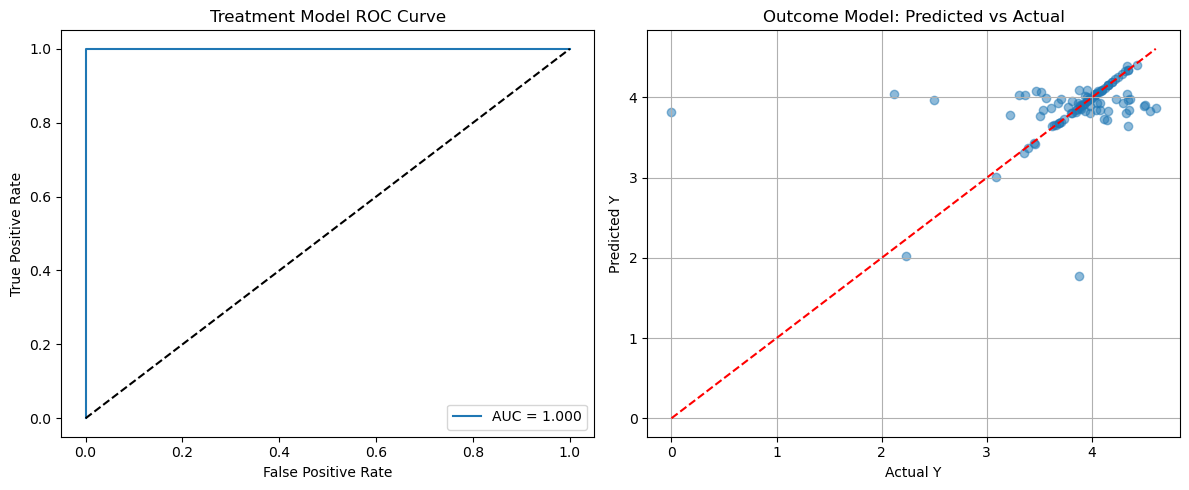

In [42]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
from econml.dml import CausalForestDML

def evaluate_base_models(X_train, T_train, Y_train):
    # Treatment model (classification)
    model_t = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )

    # Outcome model (regression)
    model_y = RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        n_jobs=-1
    )

    # Cross-validation scores for treatment model (ROC-AUC)
    t_scores = cross_val_score(model_t, X_train, T_train, cv=3, scoring='roc_auc')

    # Cross-validation scores for outcome model (Negative Mean Squared Error)
    y_scores = cross_val_score(model_y, X_train, Y_train, cv=3, scoring='neg_mean_squared_error')

    print(f"Treatment Model CV ROC-AUC: {t_scores.mean():.3f} (±{t_scores.std()*2:.3f})")
    print(f"Outcome Model CV MSE: {-y_scores.mean():.3f} (±{y_scores.std()*2:.3f})")

    # Fit final models
    model_t.fit(X_train, T_train)
    model_y.fit(X_train, Y_train)

    return model_t, model_y


def plot_roc_curve(y_true, y_pred, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} ROC Curve')
    plt.legend()

def plot_pred_vs_actual(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel("Actual Y")
    plt.ylabel("Predicted Y")
    plt.title(f"{title}: Predicted vs Actual")
    plt.grid()

def plot_model_performance(model_t, model_y, X_test, T_test, Y_test):
    plt.figure(figsize=(12, 5))

    # Treatment model ROC curve
    plt.subplot(1, 2, 1)
    T_pred = model_t.predict_proba(X_test)[:, 1]
    plot_roc_curve(T_test, T_pred, "Treatment Model")

    # Outcome model: Predicted vs. Actual Plot
    plt.subplot(1, 2, 2)
    Y_pred = model_y.predict(X_test)
    plot_pred_vs_actual(Y_test, Y_pred, "Outcome Model")

    plt.tight_layout()
    plt.show()

def fit_causal_forest(model_t, model_y, X_train, T_train, Y_train):
    causal_forest = CausalForestDML(
        model_t=model_t,
        model_y=model_y,
        discrete_treatment=True,
        discrete_outcome=False
    )

    causal_forest.fit(Y_train, T_train, X=X_train)
    return causal_forest

# Run the analysis
model_t, model_y = evaluate_base_models(X_train, T_train, Y_train)
plot_model_performance(model_t, model_y, X_test, T_test, Y_test)
causal_forest = fit_causal_forest(model_t, model_y, X_train, T_train, Y_train)

In [43]:
shap_values = causal_forest.shap_values(X_test)

<Axes: xlabel='SHAP value (impact on model output)'>

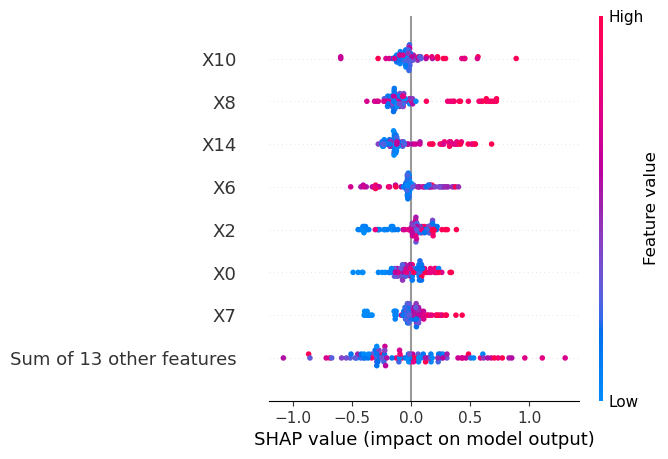

In [44]:
import numpy as np

# Get SHAP values object
shap_val = shap_values['Y0']['T0_1.0']

# Calculate spread (max - min) for each feature
spread = np.ptp(shap_val.values, axis=0)  # np.ptp computes peak-to-peak (max - min)

# Get indices sorted by spread in descending order
sorted_indices = np.argsort(spread)[::-1]

# Generate the plot with custom ordering
shap.plots.beeswarm(
    shap_val,
    max_display=8,
    plot_size=(5, 5),
    show=False,
    order=sorted_indices  # Pass sorted indices to order by spread
)

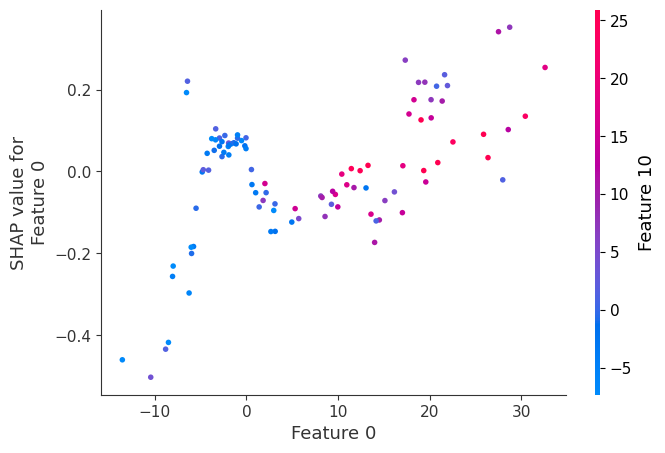

In [39]:
shap.dependence_plot(0, shap_values['Y0']['T0_1.0'].values, X_test)

In [9]:
# Step 3: Define Y1 and Y2 Separately Based Only on Their Own X
y1 = -3 * X1[:, 0] + 1.5 * (X1[:, 1] + X1[:, 2]) + np.random.normal(0, 0.1, size=(n_samples // 2))
y2 = 5 * X2[:, 0] + 2.5 * (X2[:, 1] + X2[:, 2]) + np.random.normal(0, 0.1, size=(n_samples // 2))

# Step 4: Standardize Y1 and Y2 Within Each Disease Group
scaler_y = StandardScaler()
y1 = scaler_y.fit_transform(y1.reshape(-1, 1)).flatten()
y2 = scaler_y.fit_transform(y2.reshape(-1, 1)).flatten()

# Step 5: Merge into Full Y Dataset
y = np.hstack([y1, y2])

 99%|===================| 4936/5000 [01:12<00:00]        

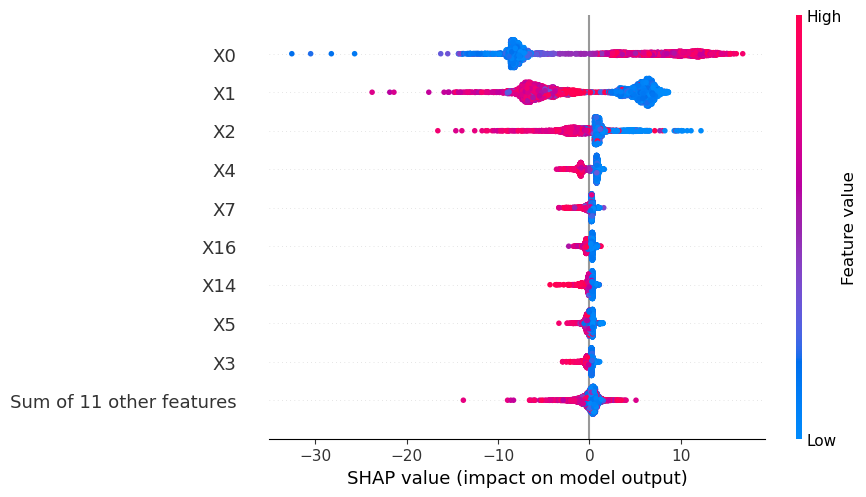

In [10]:
# Step 7: Fit Causal Forest Model
est = CausalForestDML(random_state=123)
est.fit(y, T, X=X, W=W)

# Step 8: Compute SHAP Values
shap_values = est.shap_values(X)

# Step 9: Plot SHAP Interaction Effects
shap.plots.beeswarm(shap_values['Y0']['T0'])

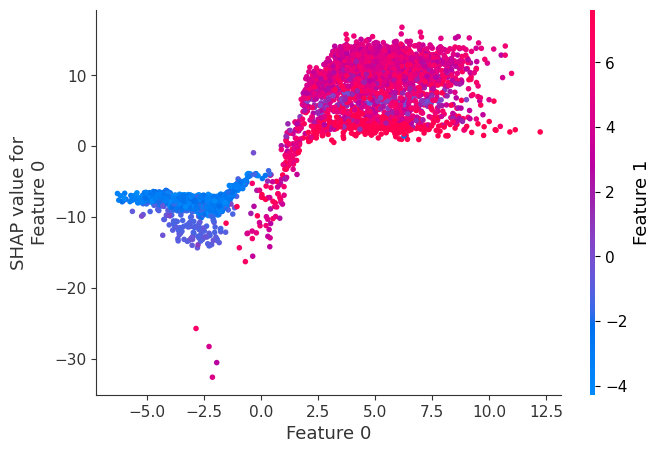

In [11]:
shap.dependence_plot(0, shap_values['Y0']['T0'].values, X)

In [28]:
# Step 3: Define Y1 and Y2 Separately Based Only on Their Own X
y1 = 5 * X1[:, 0] + 1.5 * (X1[:, 1] + X1[:, 2]) + np.random.normal(0, 0.1, size=(n_samples // 2))
y2 = 3 * X2[:, 0] + 2.5 * (X2[:, 1] + X2[:, 2]) + np.random.normal(0, 0.1, size=(n_samples // 2))

# Step 4: Standardize Y1 and Y2 Within Each Disease Group
scaler_y = StandardScaler()
y1 = scaler_y.fit_transform(y1.reshape(-1, 1)).flatten()
y2 = scaler_y.fit_transform(y2.reshape(-1, 1)).flatten()

# Step 5: Merge into Full Y Dataset
y = np.hstack([y1, y2])

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.783e+01, tolerance: 5.000e-01
  model = cd_fast.enet_coordinate_descent(
100%|===================| 4987/5000 [01:10<00:00]        

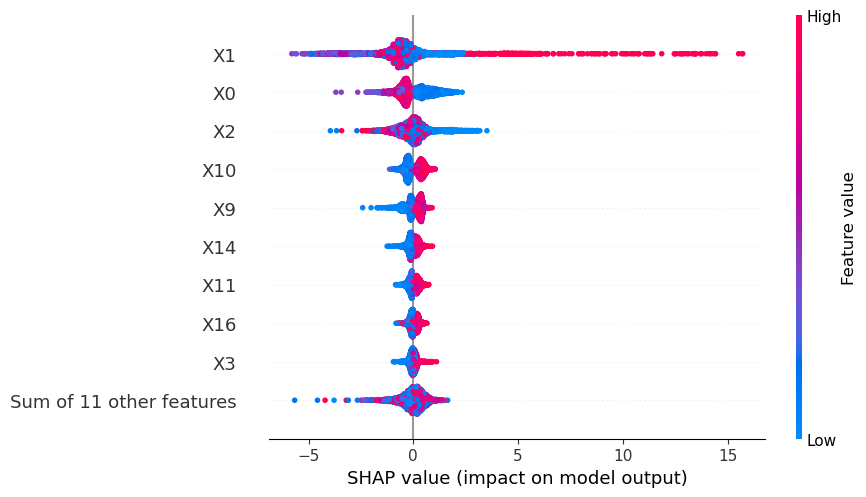

In [29]:
# Step 7: Fit Causal Forest Model
est = CausalForestDML(random_state=123)
est.fit(y, T, X=X, W=W)

# Step 8: Compute SHAP Values
shap_values = est.shap_values(X)

# Step 9: Plot SHAP Interaction Effects
shap.plots.beeswarm(shap_values['Y0']['T0'])

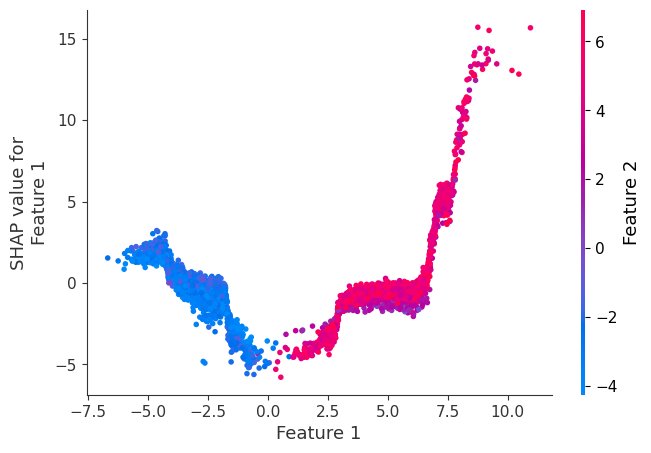

In [31]:
shap.dependence_plot(1, shap_values['Y0']['T0'].values, X)

In [126]:
import pandas as pd
X1 = pd.DataFrame(X1, columns=[f"{i}" for i in range(X1.shape[1])])
X2 = pd.DataFrame(X2, columns=[f"{i}" for i in range(X2.shape[1])])

# 2. Train RandomForest Model 1 on (X1, Y1)
model1 = RandomForestRegressor(n_estimators=500, random_state=42)
model1.fit(X1, y1)

# 3. Train RandomForest Model 2 on (X2, Y2)
model2 = RandomForestRegressor(n_estimators=500, random_state=42)
model2.fit(X2, y2)

# 4. Compute SHAP Values
explainer1 = shap.TreeExplainer(model1, X1)
shap_values1 = explainer1(X1)

explainer2 = shap.TreeExplainer(model2, X2)
shap_values2 = explainer2(X2)

# 6. Save SHAP Values to CSV
shap_df1 = pd.DataFrame(shap_values1.values, columns=X1.columns)
shap_df2 = pd.DataFrame(shap_values2.values, columns=X2.columns)

 96%|=================== | 240/250 [00:12<00:00]       

In [127]:
shap_importance1 = shap_df1.abs().mean(axis=0)
shap_importance2 = shap_df2.abs().mean(axis=0)

In [128]:
shap_importance3 = shap_importance1*shap_importance2

In [111]:
result_final=[]
result_final1=[]

In [129]:
# 4. Sort Feature Importance in Descending Order
shap_importance_sorted = shap_importance3.sort_values(ascending=False)
result_final.append(shap_importance_sorted)
result_final1.append((shap_importance1,shap_importance2))

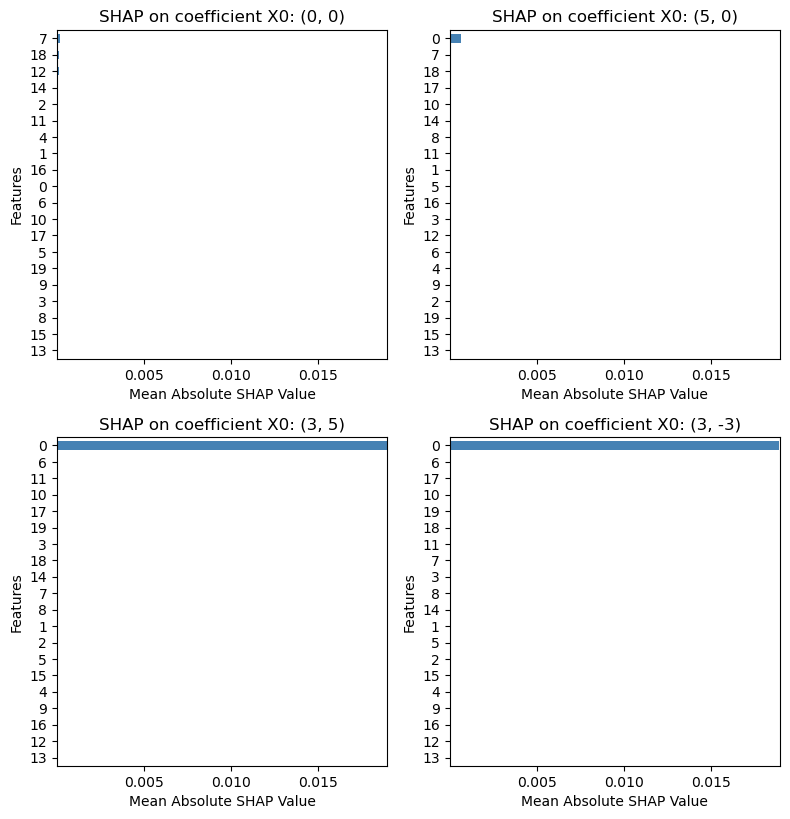

In [130]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming result_final is a list of 7 sorted SHAP importances
# Each item in result_final is a pd.Series with features as index

# Determine the global SHAP value range for consistent scaling
shap_min = min(s.min() for s in result_final)
shap_max = max(s.max() for s in result_final)

# Plot each SHAP importance on the same scale with 2 rows and 2 columns
plt.figure(figsize=(8, 16))

label=[(0,0),(5,0),(3,5),(3,-3)]
for i, shap_importance_sorted in enumerate(result_final):
    ax = plt.subplot(4, 2, i + 1)
    shap_importance_sorted.plot(kind='barh', color='steelblue', ax=ax)
    ax.set_xlim(shap_min, shap_max)  # Ensure consistent x-axis across all plots
    ax.invert_yaxis()  # Highest values on top
    ax.set_xlabel("Mean Absolute SHAP Value")
    ax.set_ylabel("Features")
    ax.set_title(f"SHAP on coefficient X0: {label[i]}")
    
    # Set aspect ratio to equal
    ax.set_aspect('auto')

plt.tight_layout()
plt.show()


/var/folders/gd/dlwqz6yj1lqcll0r324r91zr0000gn/T/ipykernel_93879/3641581170.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val1 = shap_importance_sorted1[0]
/var/folders/gd/dlwqz6yj1lqcll0r324r91zr0000gn/T/ipykernel_93879/3641581170.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val2 = shap_importance_sorted2[0]
/var/folders/gd/dlwqz6yj1lqcll0r324r91zr0000gn/T/ipykernel_93879/3641581170.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use

0.0070486168161509755 0.005282372412732784
0.12407815564881738 0.005282372412732784
0.12406916992858348 0.1529344259734733
0.12406916992858348 0.15269533643932323


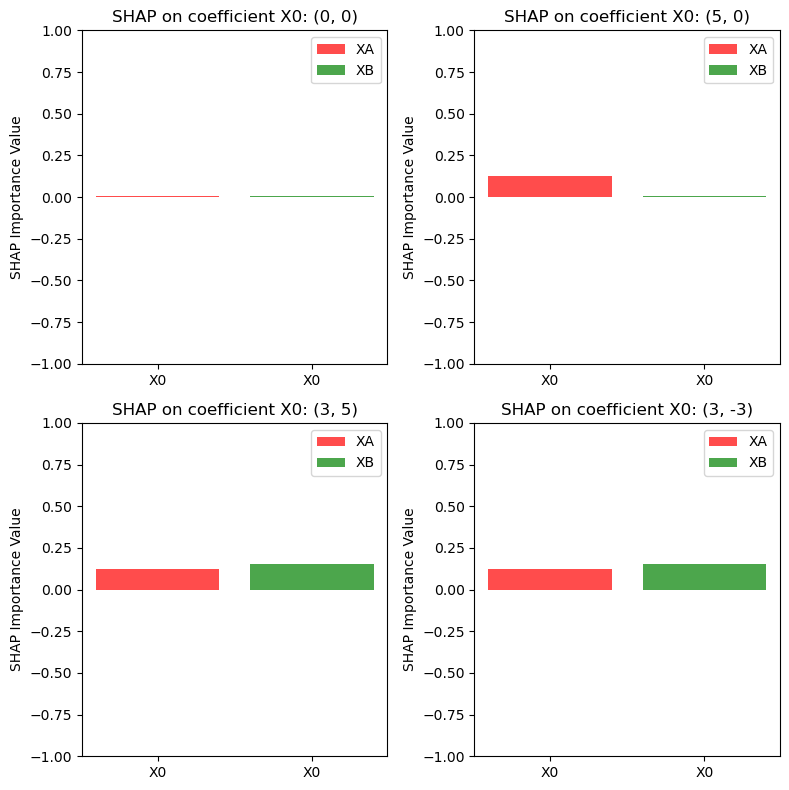

In [152]:
import matplotlib.pyplot as plt

# Assuming result_final1 is a list of 4 tuples, where each tuple contains
# shap_importance_sorted1 and shap_importance_sorted2

plt.figure(figsize=(8, 8))

for i, (shap_importance_sorted1, shap_importance_sorted2) in enumerate(result_final1):
    # Extract first elements
    val1 = shap_importance_sorted1[0]
    val2 = shap_importance_sorted2[0]
    
    # Create subplots with a 2x2 layout
    ax = plt.subplot(2, 2, i + 1)
    print(val1, val2)
    
    # Plot downward bar for -val1 and upward bar for val2
    ax.bar('val1', val1, color='red', alpha=0.7, label='XA')  # Negative of val1 (downward)
    ax.bar('val2', val2, color='green', alpha=0.7, label='XB')  # Positive val2 (upward)
    
    # Set y-axis limits to make sure both bars fit and are comparable
    ax.set_ylim([-1, 1])  # Adjust this limit to your actual range
    ax.set_ylabel("SHAP Importance Value")
    
    # Set x-axis labels and ticks
    ax.set_xticks(['val1', 'val2'])
    ax.set_xticklabels(['X0', 'X0'])
    
    # Set title for each plot
    ax.set_title(f"SHAP on coefficient X0: {label[i]}")

    # Add a legend
    ax.legend()

plt.tight_layout()
plt.show()


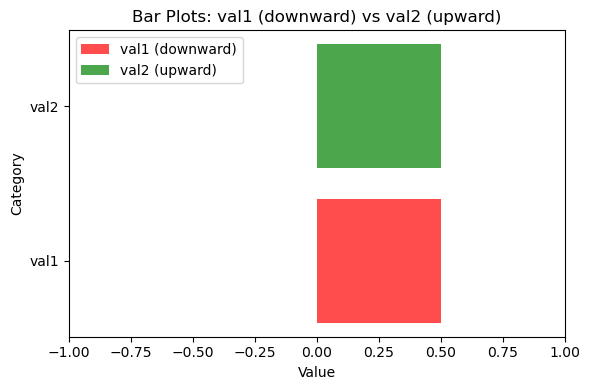

In [154]:
import matplotlib.pyplot as plt

# Example values (replace these with the actual values you have)
val1 = 0.5  # val1 is positive, but we want to plot it as negative
val2 = 0.5  # val2 is positive

plt.figure(figsize=(6, 4))

# Bar plot for val1 (downward)
plt.barh(['val1'], val1, color='red', alpha=0.7, label='val1 (downward)')

# Bar plot for val2 (upward)
plt.barh(['val2'], val2, color='green', alpha=0.7, label='val2 (upward)')

# Set limits for better visualization
plt.xlim([-1, 1])  # Adjust this limit as needed based on your data

# Set labels and title
plt.xlabel("Value")
plt.ylabel("Category")
plt.title("Bar Plots: val1 (downward) vs val2 (upward)")

# Show legend
plt.legend()

plt.tight_layout()
plt.show()
